##Data preprocessing

Before training, perform simple preprocessing on the data set and check the basic format of the data.

In [1]:

# Import package
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal

## Read file

The basic code tree setup looks like this:

```
PTB-XL-CLASSFIER
├── code
├── ├── dataPreprocess.ipynb
├── data
    ├── ptbxl_database.csv
    ├── scp_statements.csv
    ├── records100
    │   ├── 00000
    │   │   ├── 00001_lr.dat
    │   │   ├── 00001_lr.hea
    │   │   ├── ...
    │   │   ├── 00999_lr.dat
    │   │   └── 00999_lr.hea
    │   ├── ...
    │   └── 21000
    │        ├── 21001_lr.dat
    │        ├── 21001_lr.hea
    │        ├── ...
    │        ├── 21837_lr.dat
    │        └── 21837_lr.hea
    └── records500
    ├── 00000
    │     ├── 00001_hr.dat
    │     ├── 00001_hr.hea
    │     ├── ...
    │     ├── 00999_hr.dat
    │     └── 00999_hr.hea
    ├── ...
    └── 21000
            ├── 21001_hr.dat
            ├── 21001_hr.hea
            ├── ...
            ├── 21837_hr.dat
            └── 21837_hr.hea
```


In [2]:
#Set the read file path
path = 'D:/Test Jupyter/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

sampling_rate = 500

In [3]:

# Read the file and convert tags
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [7]:
Y.head

<bound method NDFrame.head of         patient_id    age  sex  height  weight  nurse  site      device  \
ecg_id                                                                    
1          15709.0   56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0   19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0   37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0   24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0   19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
...            ...    ...  ...     ...     ...    ...   ...         ...   
21833      17180.0   67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  300.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0   59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0   64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0   68.0    0     NaN     NaN    1.0   2.0  AT-60    

In [9]:
Y.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [5]:

# Get original signal data
X = load_raw_data(Y, sampling_rate, path)

In [6]:
X.shape

(21799, 5000, 12)

In [10]:

# Get diagnostic information in scp_statements.csv
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [11]:
agg_df.head

<bound method NDFrame.head of                                              description  diagnostic  form  \
NDT                       non-diagnostic T abnormalities         1.0   1.0   
NST_                             non-specific ST changes         1.0   1.0   
DIG                                     digitalis-effect         1.0   1.0   
LNGQT                                   long QT-interval         1.0   1.0   
NORM                                          normal ECG         1.0   NaN   
...                                                  ...         ...   ...   
BIGU   bigeminal pattern (unknown origin, SV or Ventr...         NaN   NaN   
AFLT                                      atrial flutter         NaN   NaN   
SVTAC                       supraventricular tachycardia         NaN   NaN   
PSVT             paroxysmal supraventricular tachycardia         NaN   NaN   
TRIGU  trigeminal pattern (unknown origin, SV or Vent...         NaN   NaN   

       rhythm diagnostic_class di

In [12]:
agg_df = agg_df[agg_df.diagnostic == 1]

In [13]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [14]:

#Add diagnostic information
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [19]:
Y[['scp_codes', 'diagnostic_superclass']]

,scp_codes,diagnostic_superclass
ecg_id,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",[NORM]
2,"{'NORM': 80.0, 'SBRAD': 0.0}",[NORM]
3,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
4,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
5,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
...,...,...
21833,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",[STTC]
21834,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",[NORM]
21835,"{'ISCAS': 50.0, 'SR': 0.0}",[STTC]


In [60]:
check_y=Y.loc[Y.index == 12756, ['scp_codes', 'diagnostic_superclass']]
check_y

,scp_codes,diagnostic_superclass
ecg_id,,
12756,"{'AMI': 15.0, 'NDT': 100.0, 'IVCD': 100.0, 'SR...","[CD, MI, STTC]"


In [17]:
Y.diagnostic_superclass.value_counts()

[NORM]                 9069
[MI]                   2532
[STTC]                 2400
[CD]                   1708
[CD, MI]               1297
[HYP, STTC]             781
[MI, STTC]              599
[HYP]                   535
[CD, STTC]              471
[]                      411
[NORM, CD]              407
[HYP, MI, STTC]         361
[HYP, CD]               300
[CD, MI, STTC]          223
[HYP, CD, STTC]         211
[HYP, MI]               183
[HYP, CD, MI, STTC]     156
[HYP, CD, MI]           117
[NORM, STTC]             28
[NORM, CD, STTC]          5
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, CD, MI, HYP]       1
Name: diagnostic_superclass, dtype: int64

In [15]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')


## Plot to view original data

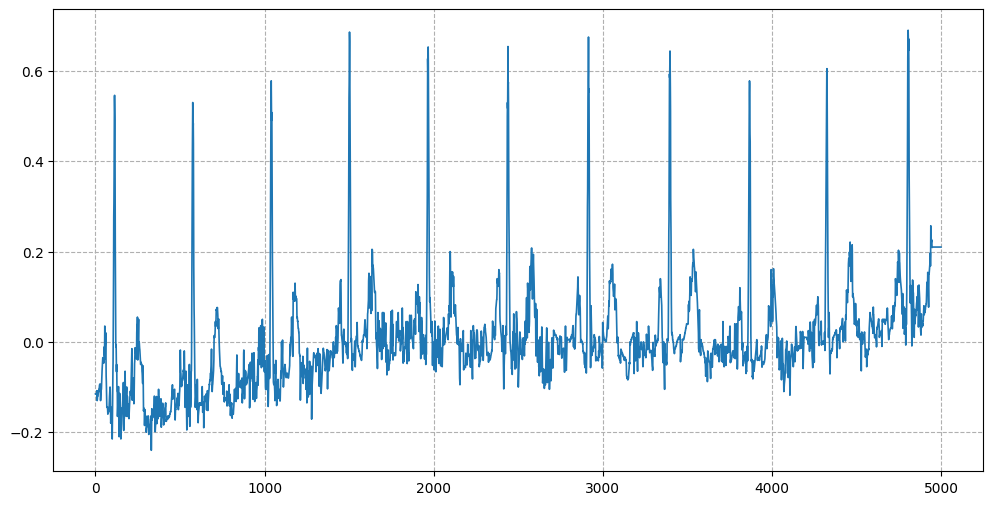

In [21]:
plt.rcParams['figure.figsize'] = (12,6) 
plt.figure()
plt.plot(X[0][:,0], linewidth=1.2)
plt.grid(linestyle='--')
# plt.yticks([])
plt.show()

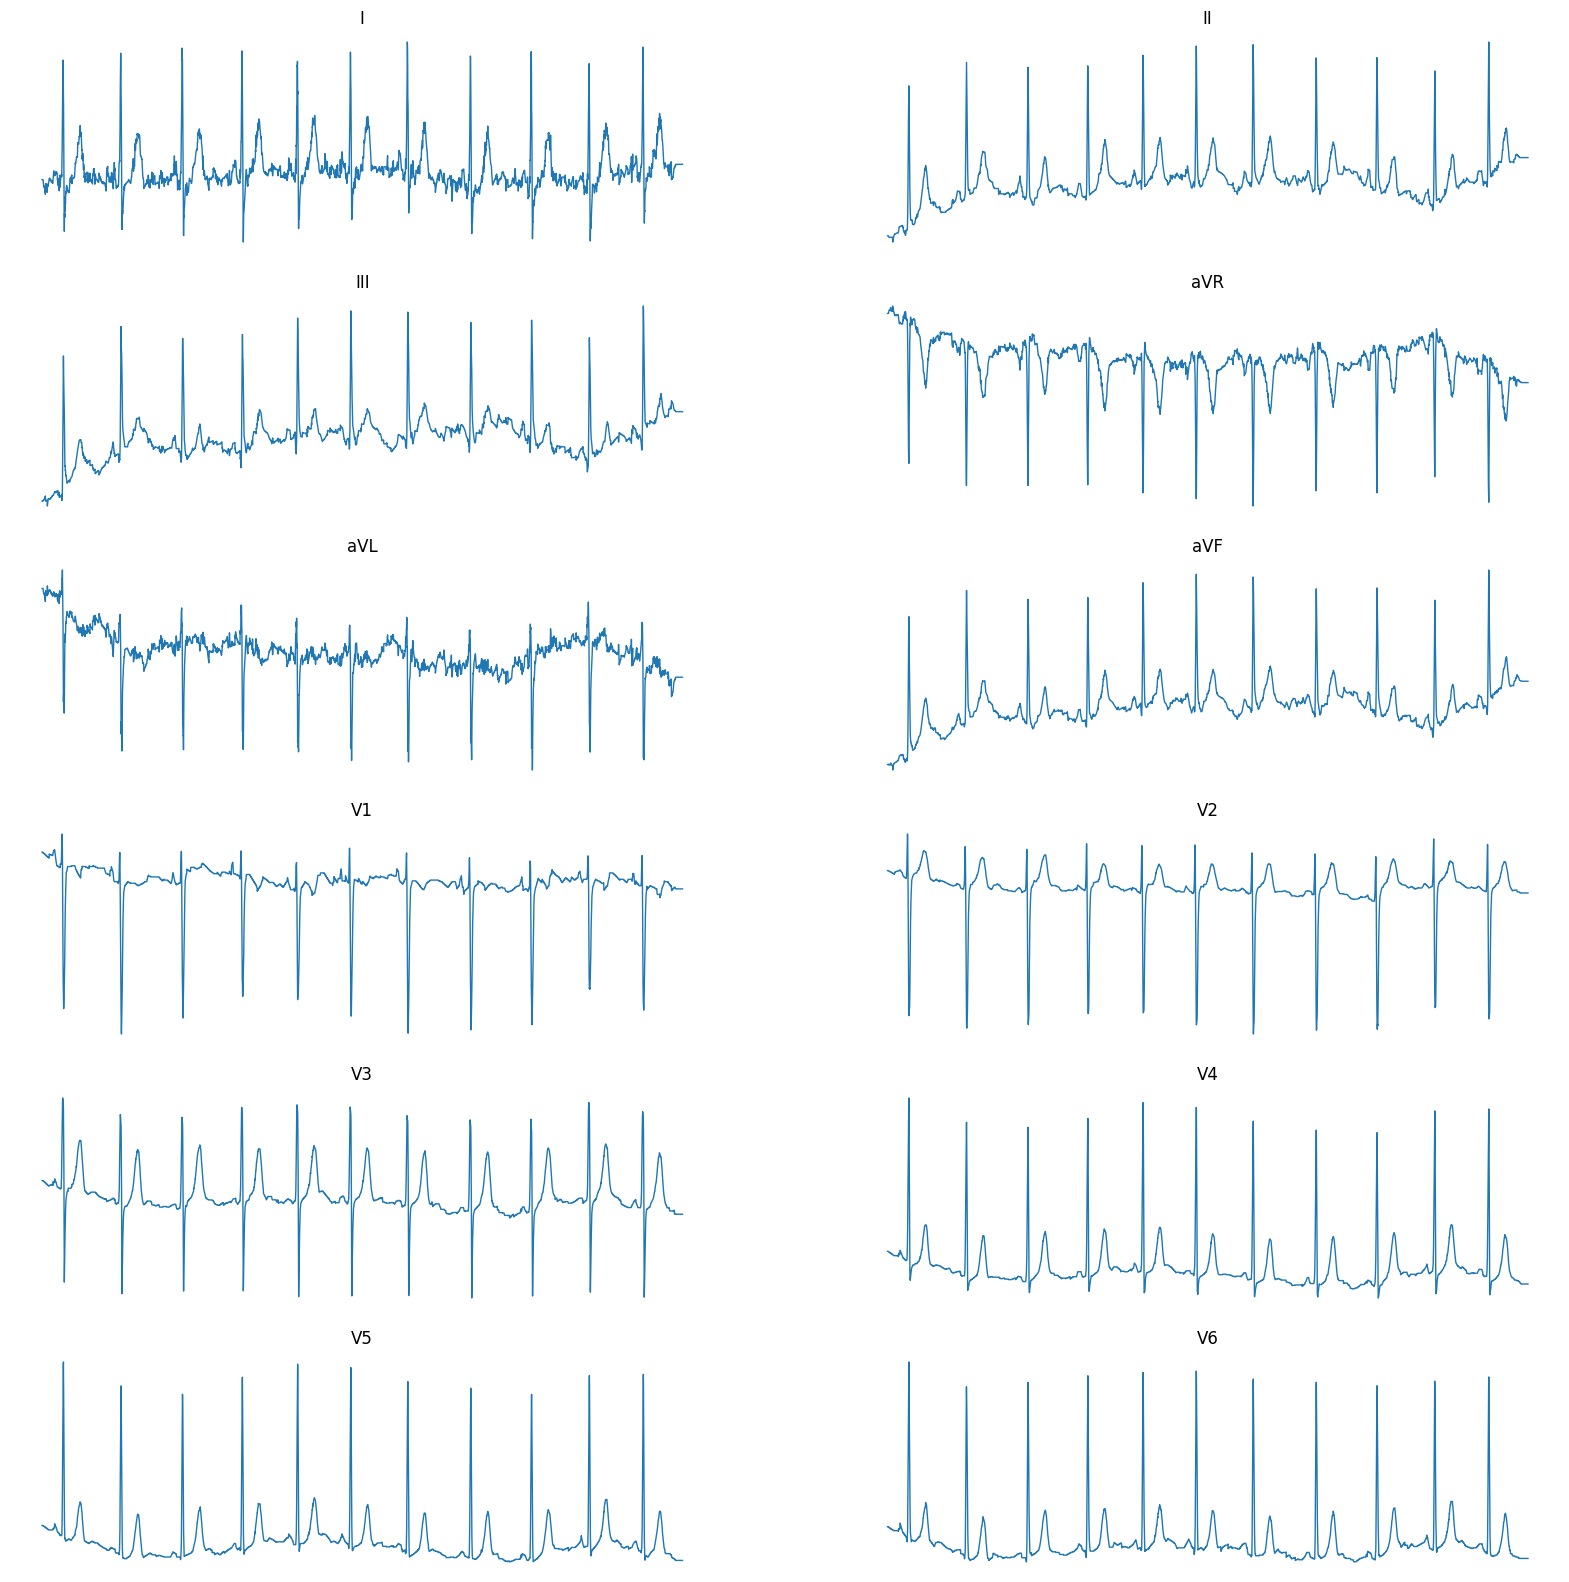

In [22]:
ecg = X[4]
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
for index in range(12):
    plt.subplot(6,2,index+1)
    plt.plot(ecg[:,index], linewidth=1)
    
    # plt.yticks(np.arange(np.min(ecg[:,index]), np.max(ecg[:,index]), 0.1))
    plt.gca()
    plt.title(titles[index])
    plt.axis('off')

plt.show()


## ECG filtering to remove baseline drift and segmentation

In [23]:
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))


### Five-point smoothing filter

In [24]:
ecg_original = X[40][:,0]
ecg_filtered = np_move_avg(ecg_original, 5)

In [25]:
#fft transform to view the spectrum
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = sampling_rate
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg

In [26]:
def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:500])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:500])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

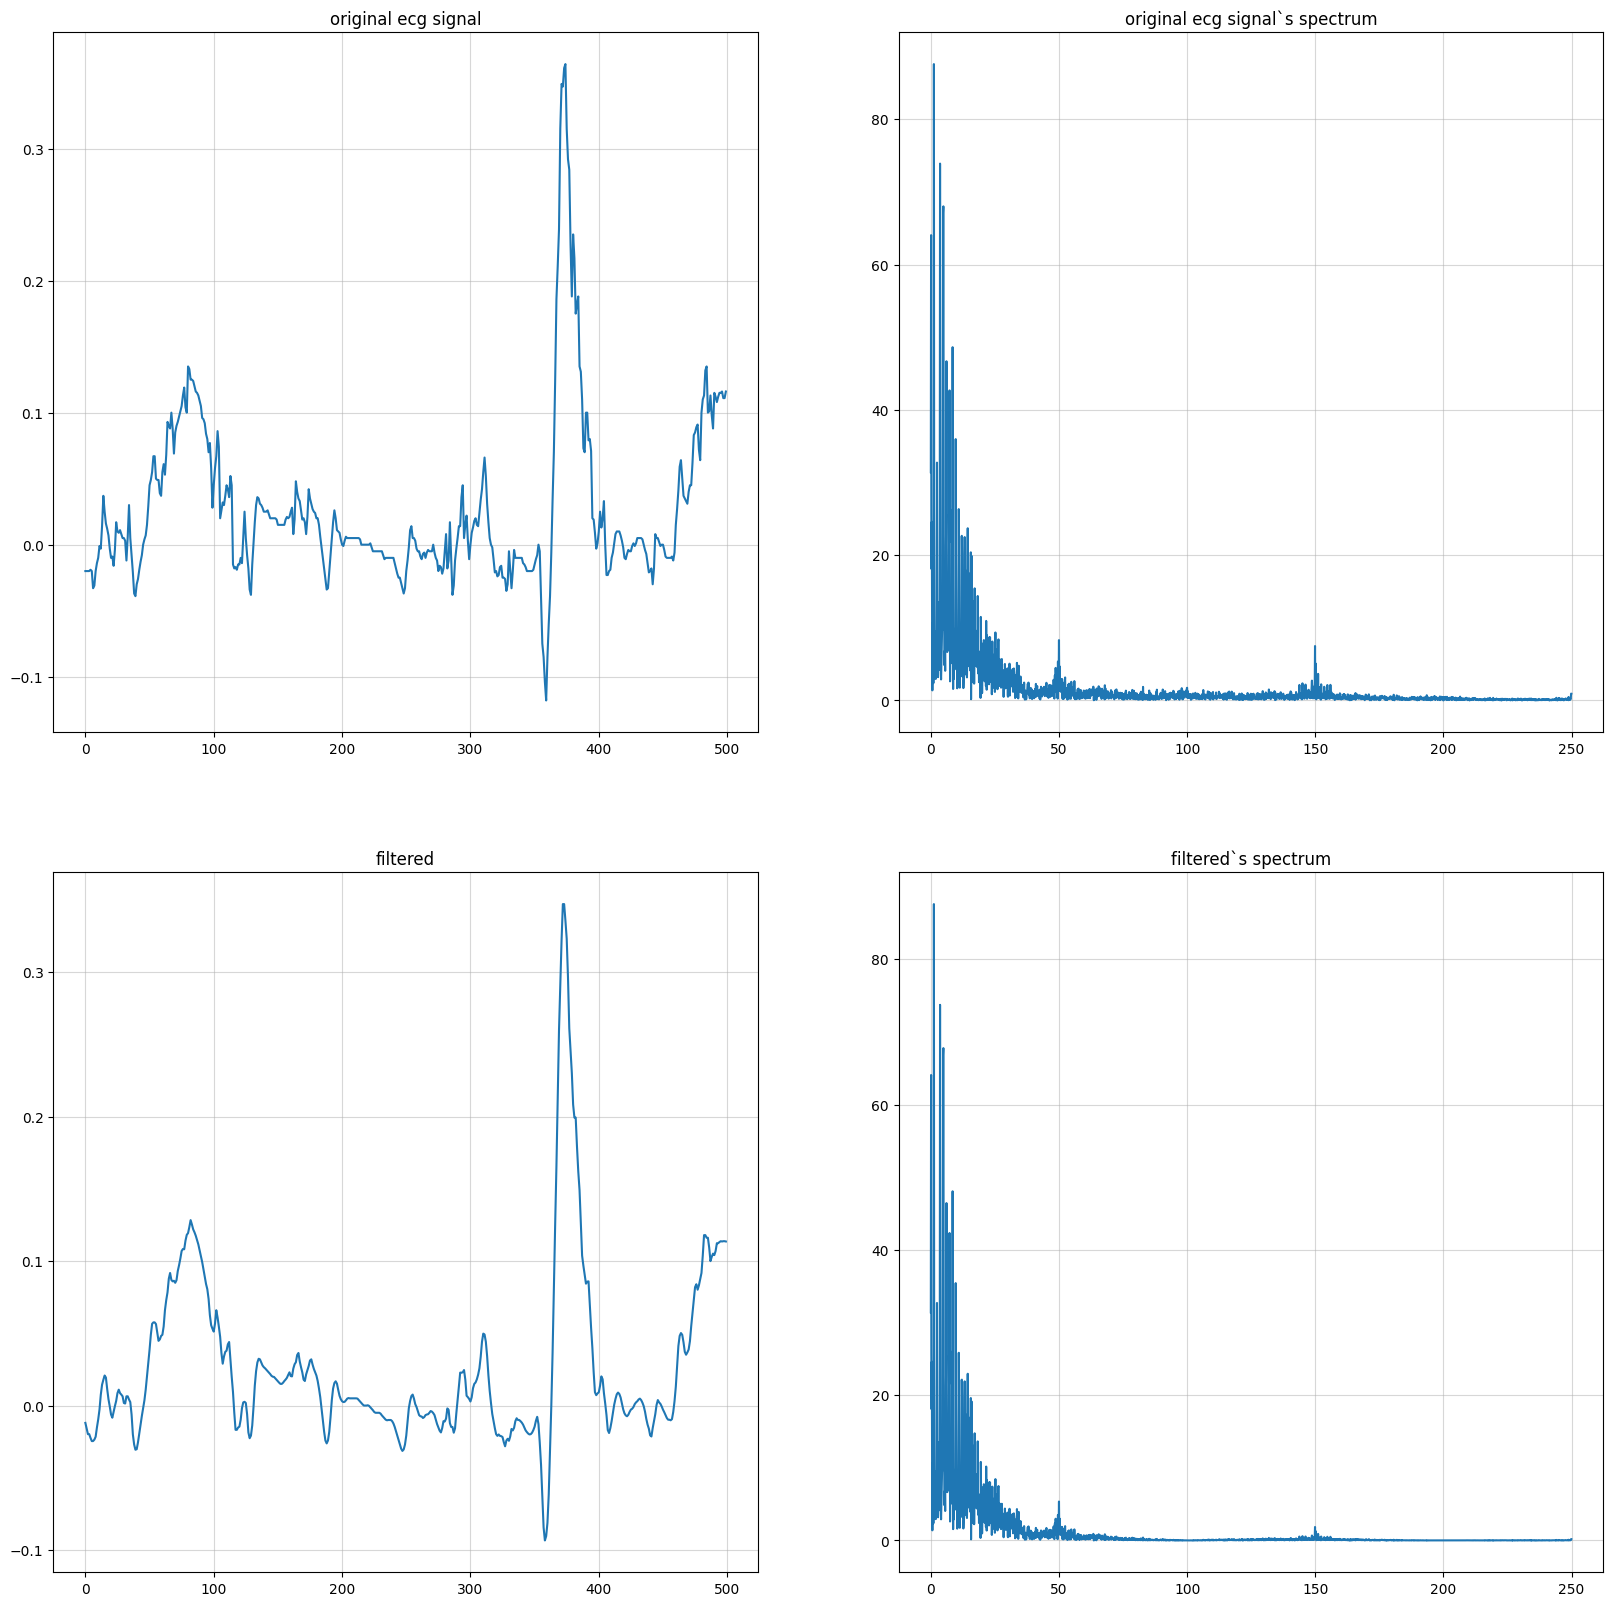

In [27]:
show_spec_dif(ecg_original, ecg_filtered, 'original ecg signal', 'filtered')


### Notch processing to filter out power frequency interference

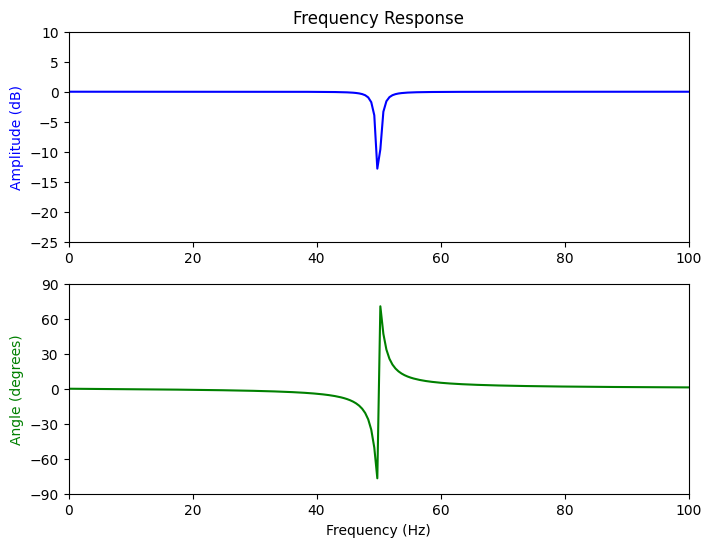

In [28]:

fs = sampling_rate # Sampling frequency
f0 = 50.0 # Power frequency interference to be removed
Q = 30.0 # Quality factor
b, a = signal.iirnotch(f0, Q, fs)
freq, h = signal.freqz(b, a, fs=fs)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

In [29]:
# Power frequency interference removal
ecg_notch = signal.filtfilt(b, a, ecg_filtered)

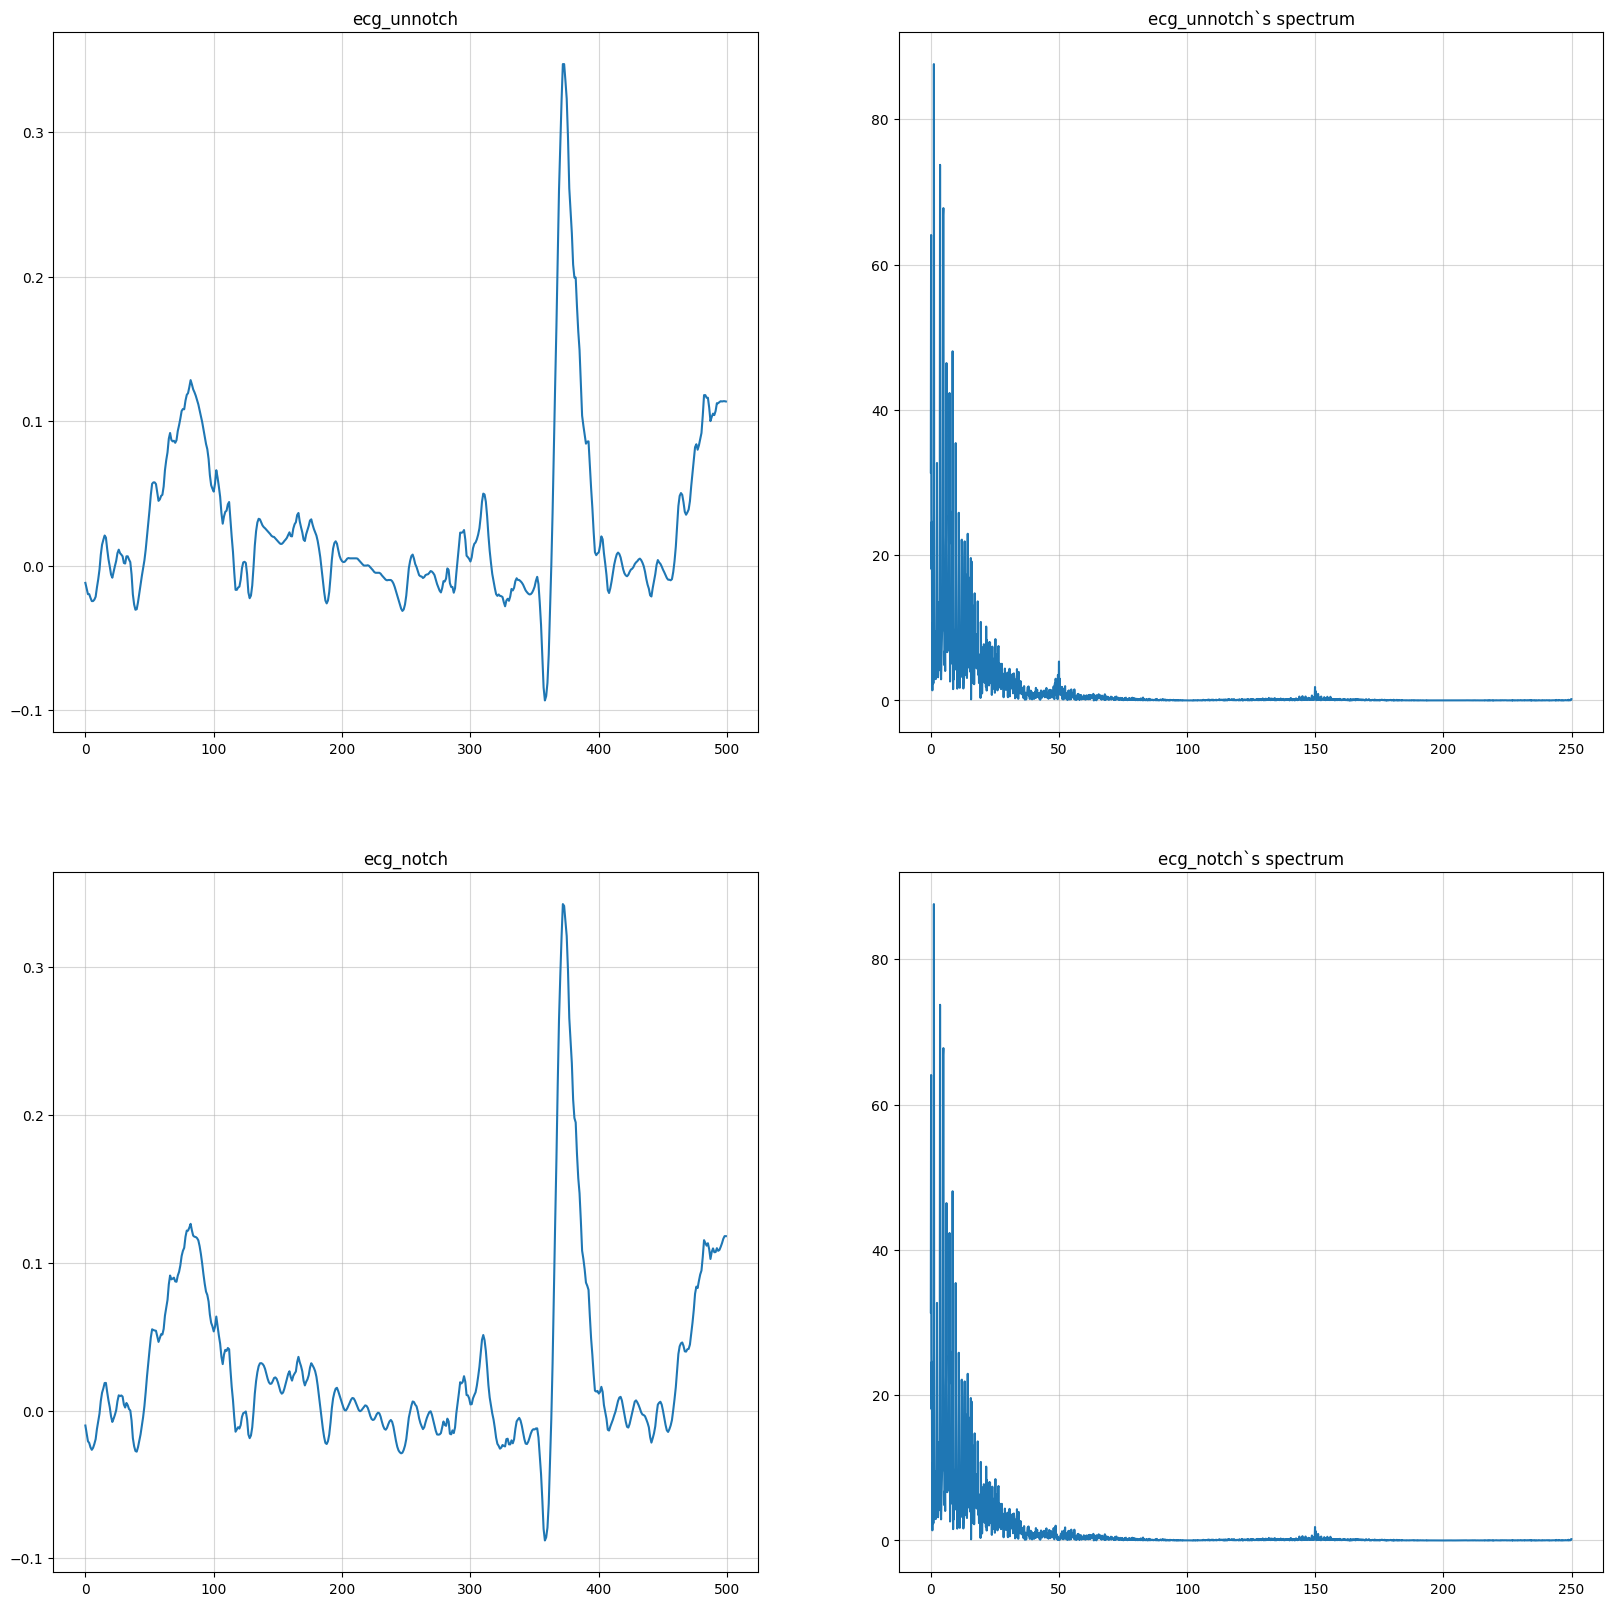

In [30]:
show_spec_dif(ecg_filtered, ecg_notch, "ecg_unnotch", "ecg_notch")

In [31]:
# Remove all lead noise
channels = 12
for index in range(len(X)):
    for channel in range(channels):
        X[index][:, channel] = np_move_avg(X[index][:, channel], 5)

In [34]:
X[0]

array([[-0.069, -0.03 ,  0.039, ..., -0.021, -0.021, -0.045],
       [-0.092, -0.04 ,  0.052, ..., -0.028, -0.028, -0.06 ],
       [-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
       ...,
       [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ],
       [ 0.168,  0.164, -0.004, ...,  0.148,  0.136,  0.144],
       [ 0.126,  0.123, -0.003, ...,  0.111,  0.102,  0.108]])

## Baseline drift

Use a high-pass filter to remove baseline drift. Baseline drift is a low-frequency interference. The frequency range is usually less than 1Hz, most of which are concentrated at 0.1Hz. It usually appears near the ST segment and Q wave.

The sampling frequency of the signal here is 500Hz. To filter out the baseline drift, obtain the baseline drift through a high-pass filter, and then subtract the baseline drift from the original signal to obtain the ECG signal without baseline drift.

The filter design is as follows:

The cutoff frequency is 0.1Hz, $wn=2*0.1/1000=0.0002$

In [ ]:
# b, a = signal.butter(8, 0.01, 'highpass')
# baseline = signal.filtfilt(b, a, ecg_filtered)

In [ ]:
# diff = ecg_filtered-baseline
# plt.figure()
# plt.subplot(311)
# plt.plot(ecg_filtered[:1000])
# plt.subplot(312)
# plt.plot(baseline[:1000])
# plt.subplot(313)
# plt.plot(diff[:1000])
# plt.show()

>The referenced paper did not remove noise. There is no noise removal here. Try to remove baseline drift.

### ECG segmentation extraction

According to the R wave segmentation of the $2$ lead channel of the 12-lead ECG, 150 data before the R wave and 350 data after the R wave

In [35]:
ecg = X[np.random.randint(len(X))][:,1]

In [36]:
def get_diff(ecg):
    ecg_diff = np.zeros(len(ecg))
    for i in range(len(ecg)-1):
        ecg_diff[i] = ecg[i+1] - ecg[i]
    ecg_diff[len(ecg)-1] = ecg[len(ecg)-1]
    return ecg_diff

In [37]:

#Detect R wave function
def checkR(ecg):
    max_val = np.max(ecg)
    min_val = np.min(ecg)
    threshold_val = (max_val-min_val)*0.7 + min_val
    index = []
    for i in range(1, len(ecg)-2):
        
        # Satisfy the difference threshold condition
        if ecg[i] == np.max(ecg[i-1:i+2]) and ecg[i] > threshold_val:
            
            # Meet heart rate interval 60-160
            if index != []:
                if i-index[-1] <= 60.0/60.0*sampling_rate and i-index[-1] >= 60.0/160.0*sampling_rate:
                    index.append(i)
            else:
                index.append(i)
    return np.array(index)

In [38]:
index = checkR(ecg)

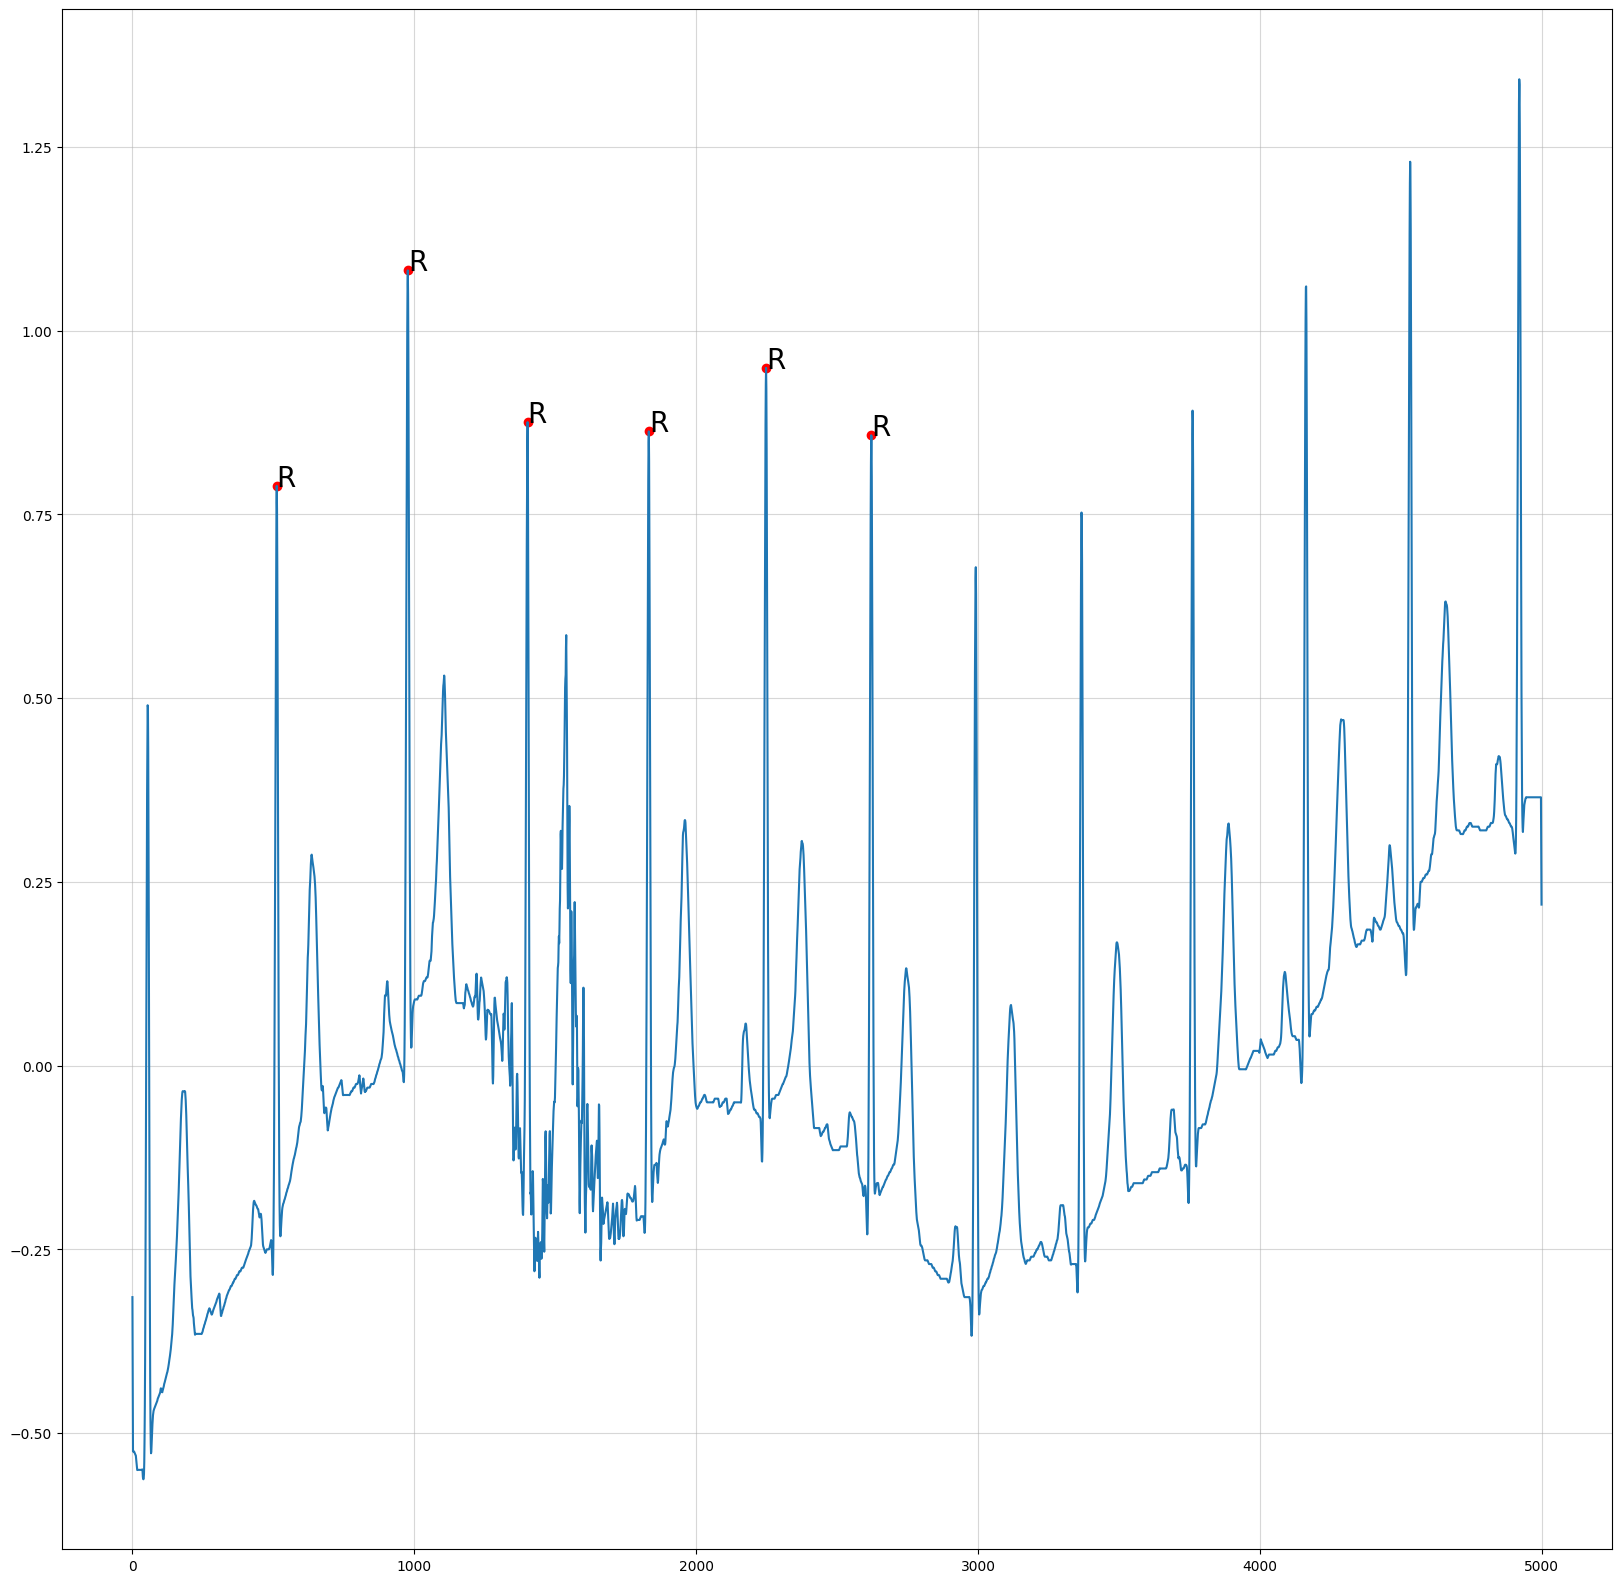

In [39]:

# Check whether R wave detection is correct
plt.figure()
plt.plot(ecg)
for i in range(len(index)):
    plt.scatter(index[i], ecg[index[i]],c='r')
    plt.annotate('R',(index[i], ecg[index[i]]), fontsize=20)
plt.show()

In [ ]:
# ecg_diff = get_diff(ecg)

In [ ]:
# plt.figure()
# plt.subplot(211)
# plt.plot(ecg)
# plt.subplot(212)
# plt.plot(ecg_diff)
# plt.show()

In [40]:
# piecewise function
def splitByR(ecg):
    index = checkR(ecg)              
    ecg_rhythm = None
    for i in range(len(index)):
        # extract a section
        if index[i]>200 and index[i]<1000-350:
            ecg_rhythm = ecg[index[i]-150:index[i]+350]
            continue
    return ecg_rhythm

In [41]:
ecg_rhythm = splitByR(ecg)

In [42]:
ecg_rhythm.size

500

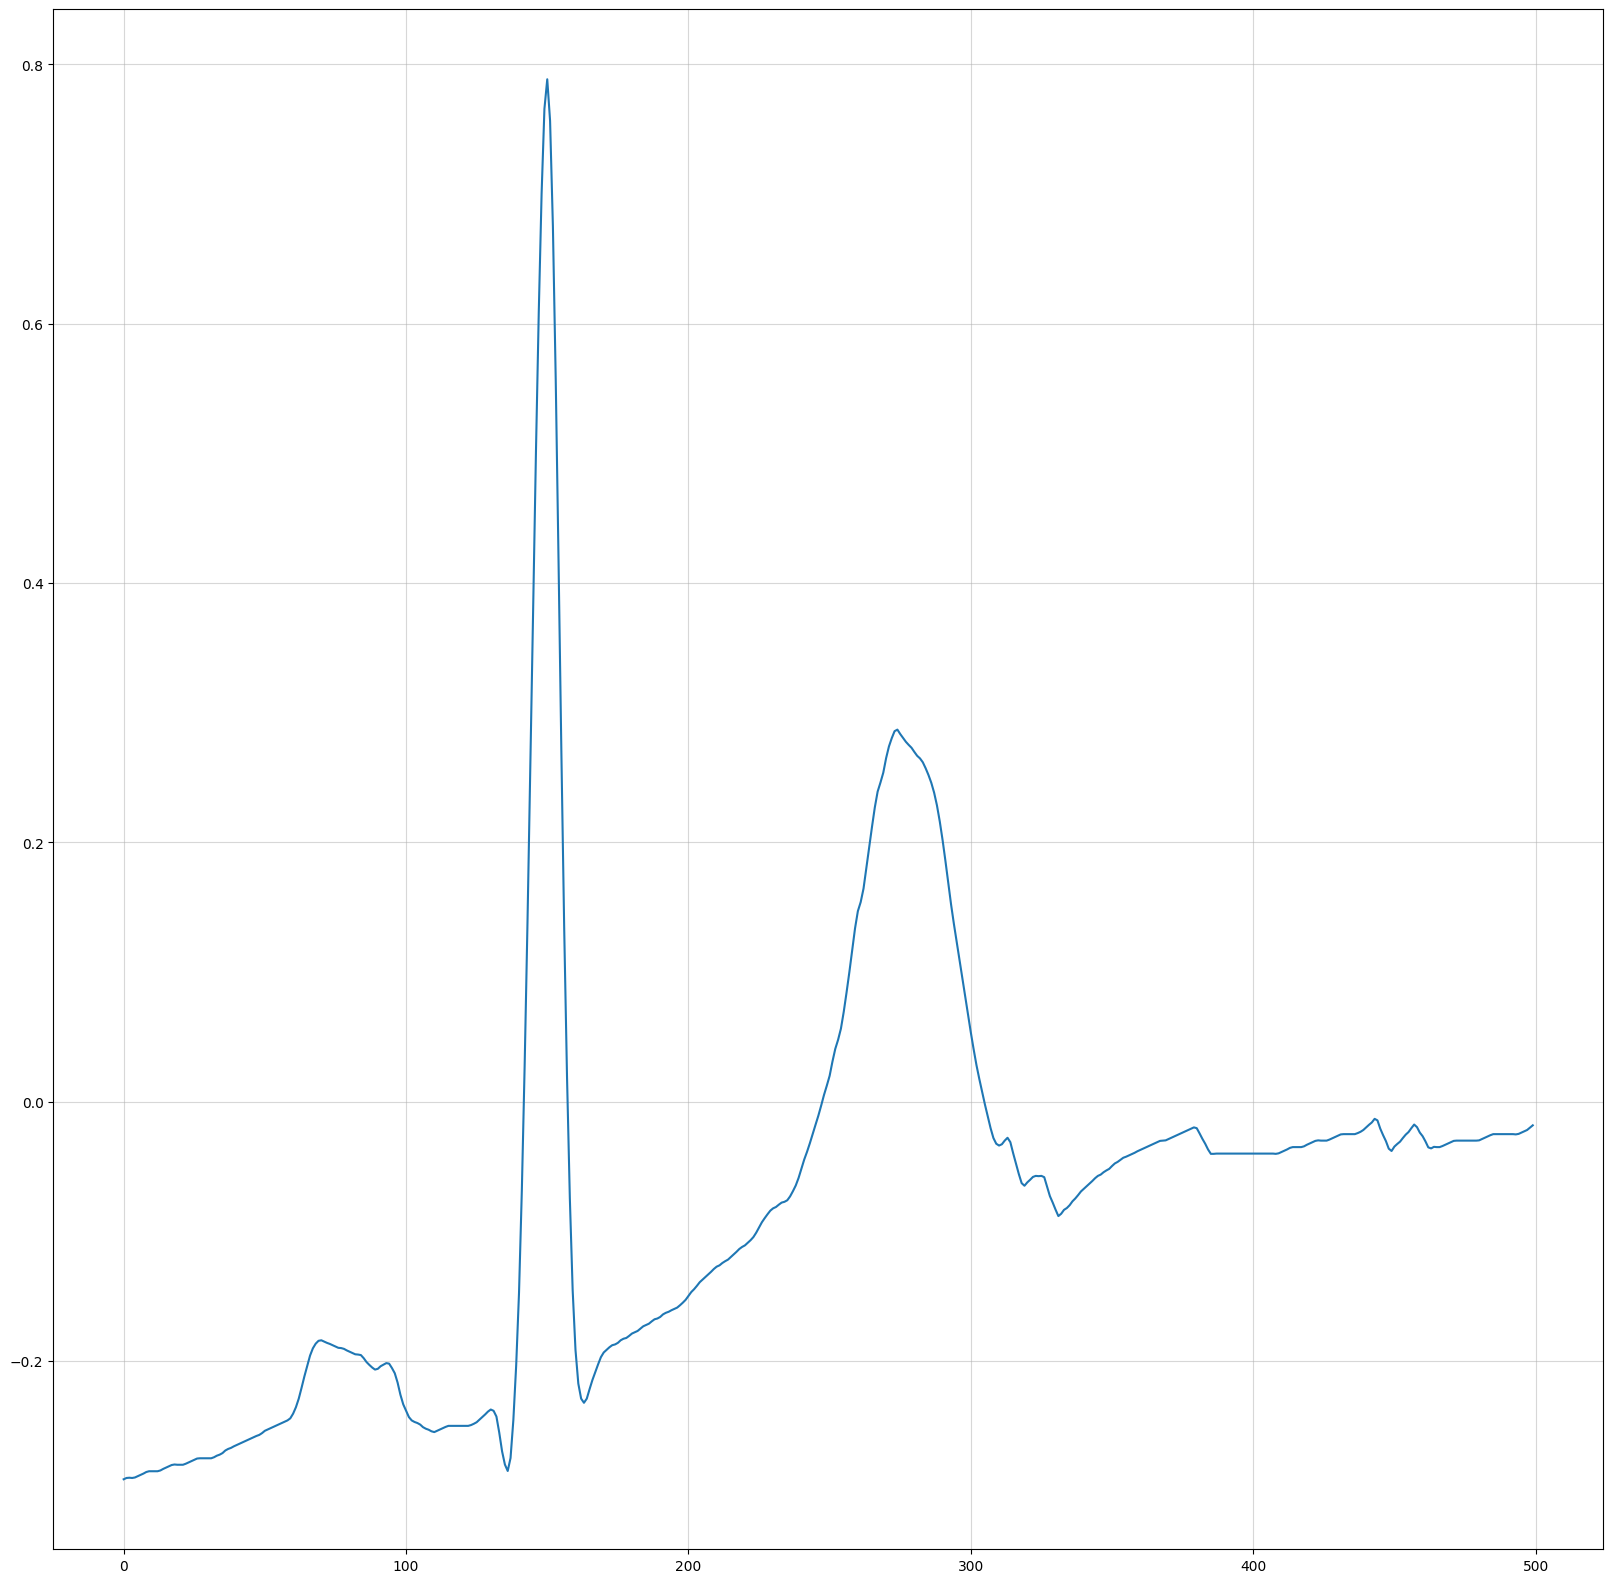

In [43]:
plt.figure()
plt.plot(ecg_rhythm)
plt.show()

In [44]:

# Extract segments from all channels of all signals
channels = 12
test_size = len(X)
ecg_rhythms = np.zeros([test_size, 500, 12])

start_time = time.time()
first_time = start_time
for index in range(test_size):
    if index%1000 == 0:
        end_time = time.time()
        print("finish %d in %d s\n" % (index, end_time - start_time))
        start_time = time.time()
    R_index = checkR(X[index][:,1])
    for i in range(len(R_index)):
        # extract a section
        if R_index[i]>200 and R_index[i]<1000-350:
            ecg_rhythms[index][:, :] = X[index][R_index[i]-150:R_index[i]+350,:]
            continue

end_time = time.time()

print('time cost:%d s'%(end_time-first_time))

finish 0 in 0 s

finish 1000 in 16 s

finish 2000 in 16 s

finish 3000 in 16 s

finish 4000 in 16 s

finish 5000 in 16 s

finish 6000 in 16 s

finish 7000 in 16 s

finish 8000 in 16 s

finish 9000 in 15 s

finish 10000 in 16 s

finish 11000 in 17 s

finish 12000 in 17 s

finish 13000 in 16 s

finish 14000 in 17 s

finish 15000 in 17 s

finish 16000 in 16 s

finish 17000 in 16 s

finish 18000 in 16 s

finish 19000 in 16 s

finish 20000 in 17 s

finish 21000 in 17 s

time cost:366 s


In [45]:
ecg_rhythms.shape

(21799, 500, 12)

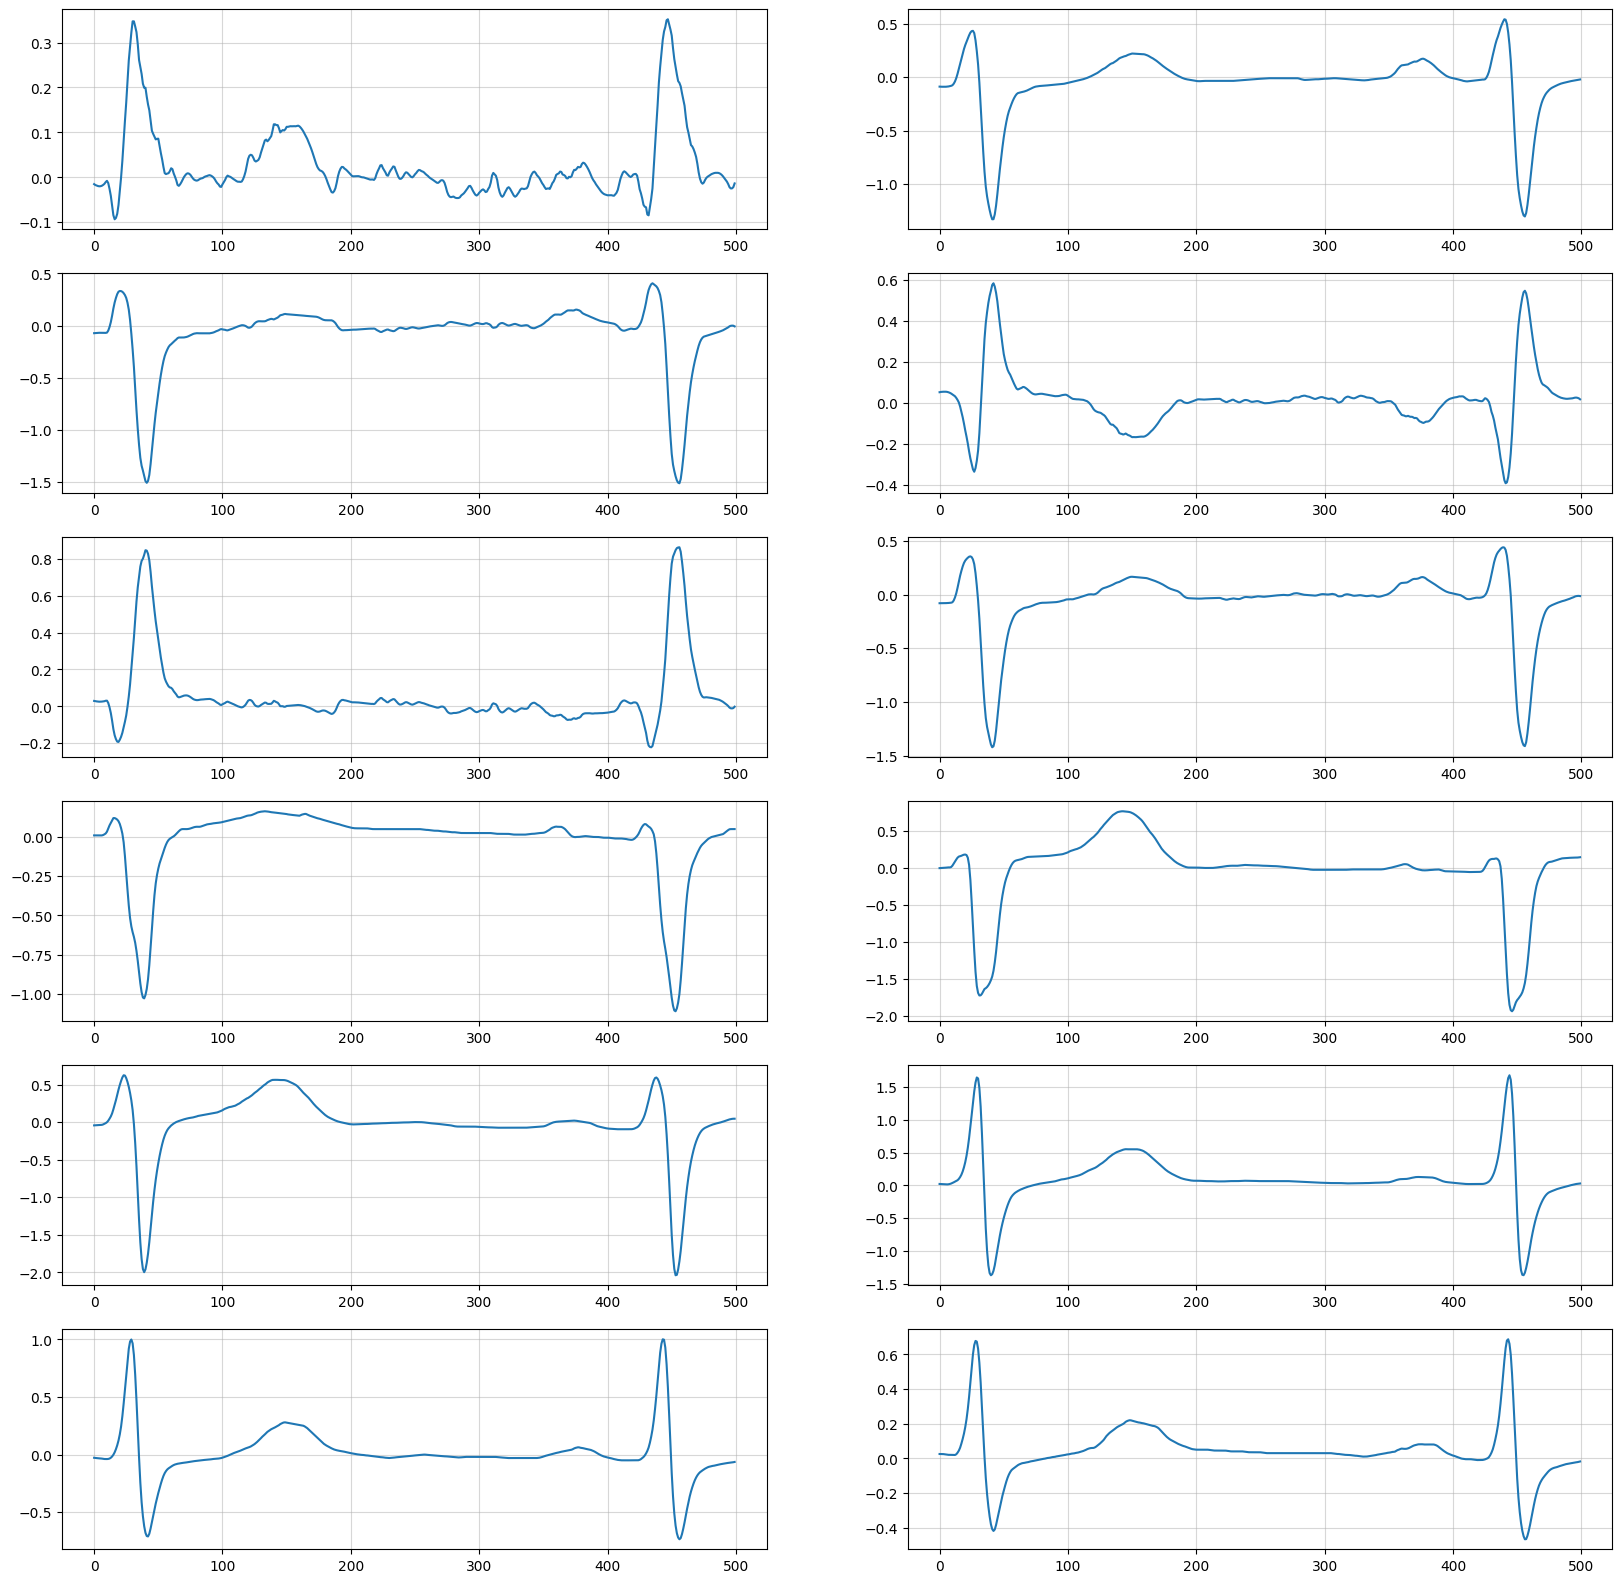

In [46]:
plt.figure()
for i in range(12):
    plt.subplot(6, 2, i+1)
    plt.plot(ecg_rhythms[40,:,i])
plt.show()

In [47]:
false_count = 0
Y['Runconfirmed'] = 0
for index in range(len(ecg_rhythms)):
    if ecg_rhythms[index].any() == np.zeros([500, 12]).any():
        false_count += 1
        Y['Runconfirmed'][index] = 1
false_count

C:\Users\ROG\AppData\Local\Temp\ipykernel_25128\2216112086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Runconfirmed'][index] = 1
C:\Users\ROG\AppData\Local\Temp\ipykernel_25128\2216112086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Runconfirmed'][index] = 1
C:\Users\ROG\AppData\Local\Temp\ipykernel_25128\2216112086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Runconfirmed'][index] = 1
C:\Users\ROG\AppDat

2594


## Divide the data set

In [48]:
# Split data into train and test
test_fold = 10
# Train
X_train = ecg_rhythms[(Y.strat_fold != test_fold)&(Y.Runconfirmed !=1)]
y_train = Y[(Y.strat_fold != test_fold)&(Y.Runconfirmed !=1)].diagnostic_superclass
# Test
X_test = ecg_rhythms[(Y.strat_fold == test_fold)&(Y.Runconfirmed !=1)]
y_test = Y[(Y.strat_fold == test_fold)&(Y.Runconfirmed !=1)].diagnostic_superclass

In [49]:
save_path = 'D:/Test Jupyter/ECG-Classfier-main/data/numpy_data_PTBXL3/'

np.save(save_path+'X_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'X_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))

In [51]:
X_train.shape

(17283, 500, 12)

In [52]:
y_train.shape

(17283,)

In [64]:
y_test.head

<bound method NDFrame.head of ecg_id
9        [NORM]
38       [NORM]
40       [NORM]
57       [NORM]
59       [NORM]
          ...  
21809    [NORM]
21812      [CD]
21818    [NORM]
21819      [CD]
21826      [MI]
Name: diagnostic_superclass, Length: 1930, dtype: object>

In [62]:
y_value = y_train.loc[12756]
y_value

['CD', 'MI', 'STTC']

In [65]:
distinct_values_counts = y_train.value_counts()
print(distinct_values_counts)

[NORM]                 7215
[MI]                   2007
[STTC]                 1903
[CD]                   1306
[CD, MI]               1022
[HYP, STTC]             629
[MI, STTC]              469
[HYP]                   422
[CD, STTC]              383
[]                      335
[NORM, CD]              322
[HYP, MI, STTC]         282
[HYP, CD]               240
[CD, MI, STTC]          188
[HYP, CD, STTC]         165
[HYP, MI]               141
[HYP, CD, MI, STTC]     124
[HYP, CD, MI]           100
[NORM, STTC]             22
[NORM, CD, STTC]          5
[NORM, HYP]               2
[NORM, CD, MI, HYP]       1
Name: diagnostic_superclass, dtype: int64
